In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

## Camera calibration

In [2]:
cameraCalibration = pickle.load(open('./calibration.p', 'rb' ))
mtx, dist = map(cameraCalibration.get,('mtx', 'dist'))

## Load images from test_images folder

In [3]:
test_images = list(map(lambda image_name: (image_name,cv2.imread(image_name)), glob.glob('./test_images/*.jpg')))

In [4]:
def undistort_image(image):
    undistort = cv2.undistort(image,mtx,dist,None,mtx)
    return undistort

def hls(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2HLS)

def grayscale(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

## Applying combined gradients

In [5]:
def abs_sobel_thresh(img,thresh=(0, 255), orient='x', sobel_kernel=3):
    if orient == 'x':
        # x-axis
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        # y-axis
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel)
    # convert to 8-bit
    scaled_sobel = np.uint8(255.0 * abs_sobel /np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])] = 1
    return grad_binary

In [6]:
def mag_thresh(image, mag_thresh=(0, 255), sobel_kernel=3):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # magnitude
    abs_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    # convert to 8-bit
    scaled_sobel = np.uint8(255.0 * abs_sobel/ np.max(abs_sobel))    
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel>=mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])] = 1
    return mag_binary

In [7]:
def dir_threshold(image, thresh=(0, np.pi/2), sobel_kernel=3):
    sobel_x = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobel_y = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # direction
    direction = np.arctan2(sobel_y,sobel_x)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction>=thresh[0]) & (direction<=thresh[1])] = 1
    return dir_binary

In [23]:
def combined_gradient(image):
    undistort = undistort_image(image)
    image_hls = hls(undistort)
    # using only S channel
    S = image_hls[:,:,2]
    L = image_hls[:,:,1]
    # Sobel X
    gradx = abs_sobel_thresh(S,(10,150))
    # Sobel y
    grady = abs_sobel_thresh(S,(10,150),'y')
    # Magnitude
    mag = mag_thresh(S,(10,150))
    # Direction
    direction = dir_threshold(S,(0.7,1))
    combined = np.zeros_like(gradx)
    # combination
    combined[((gradx==1)&(grady==1))] =1
    return combined

In [9]:
def show_images(images,ncols=2,nrows=4,cmap=None):
    n = len(test_images)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,20))
    for axis,idx in zip(axes.flat,range(ncols*nrows)):
        if(idx < n):
            axis.imshow(images[idx][1],cmap=cmap)
        axis.set_title(images[idx][0])
        axis.axis('off')

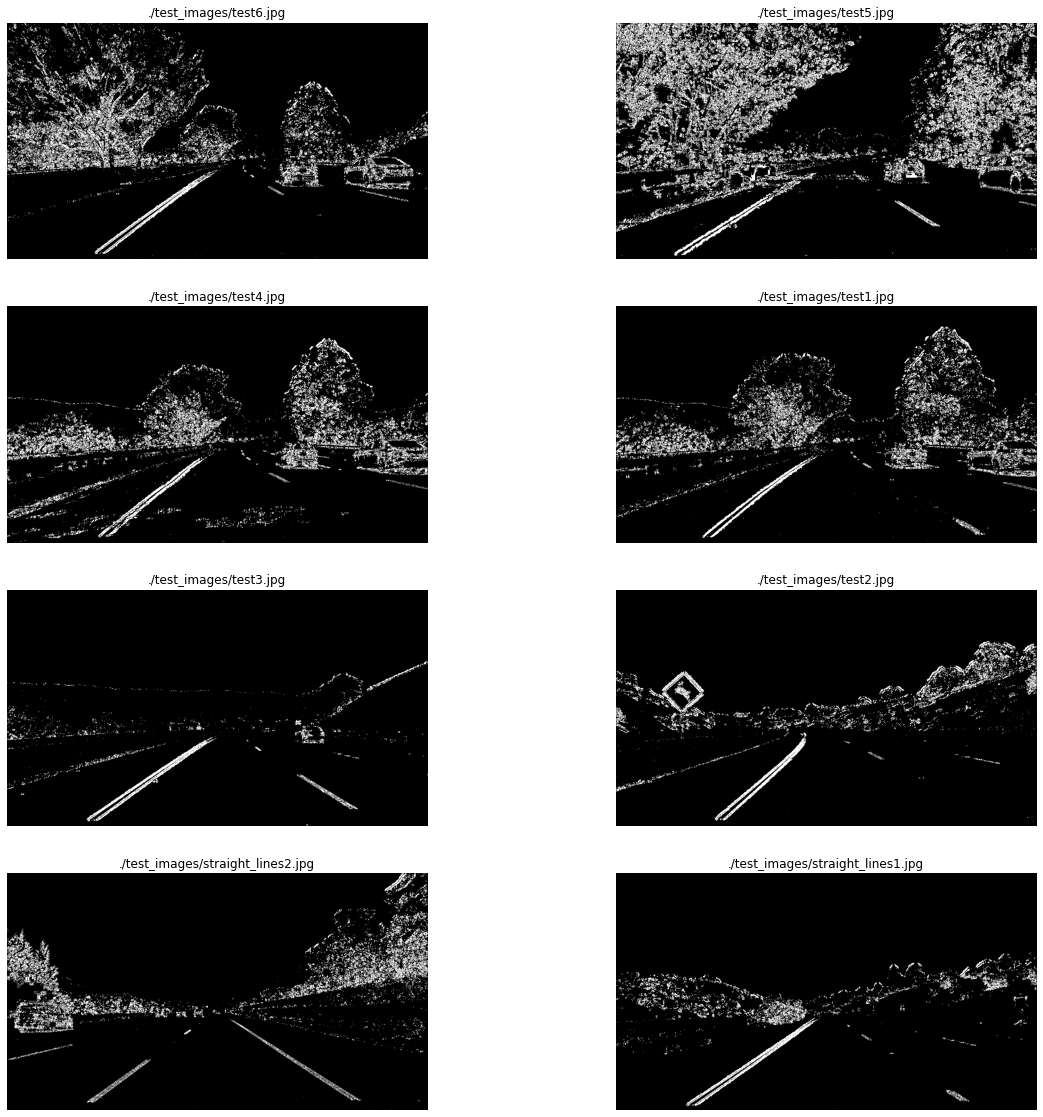

In [10]:
# combined gradient
show_images(list(map(lambda img: (img[0],combined_gradient(img[1])),test_images)),cmap='gray')

## Perspective transform 

In [11]:
perspectiveTransform = pickle.load(open('./perspective_transform.p','rb'))
M, Minv = map(perspectiveTransform.get, ('M', 'Minv'))

In [12]:
def getWarped(img):
    image_size = (img.shape[1],img.shape[0])
    # get transformed image from M
    warped = cv2.warpPerspective(img,M,image_size)
    return warped

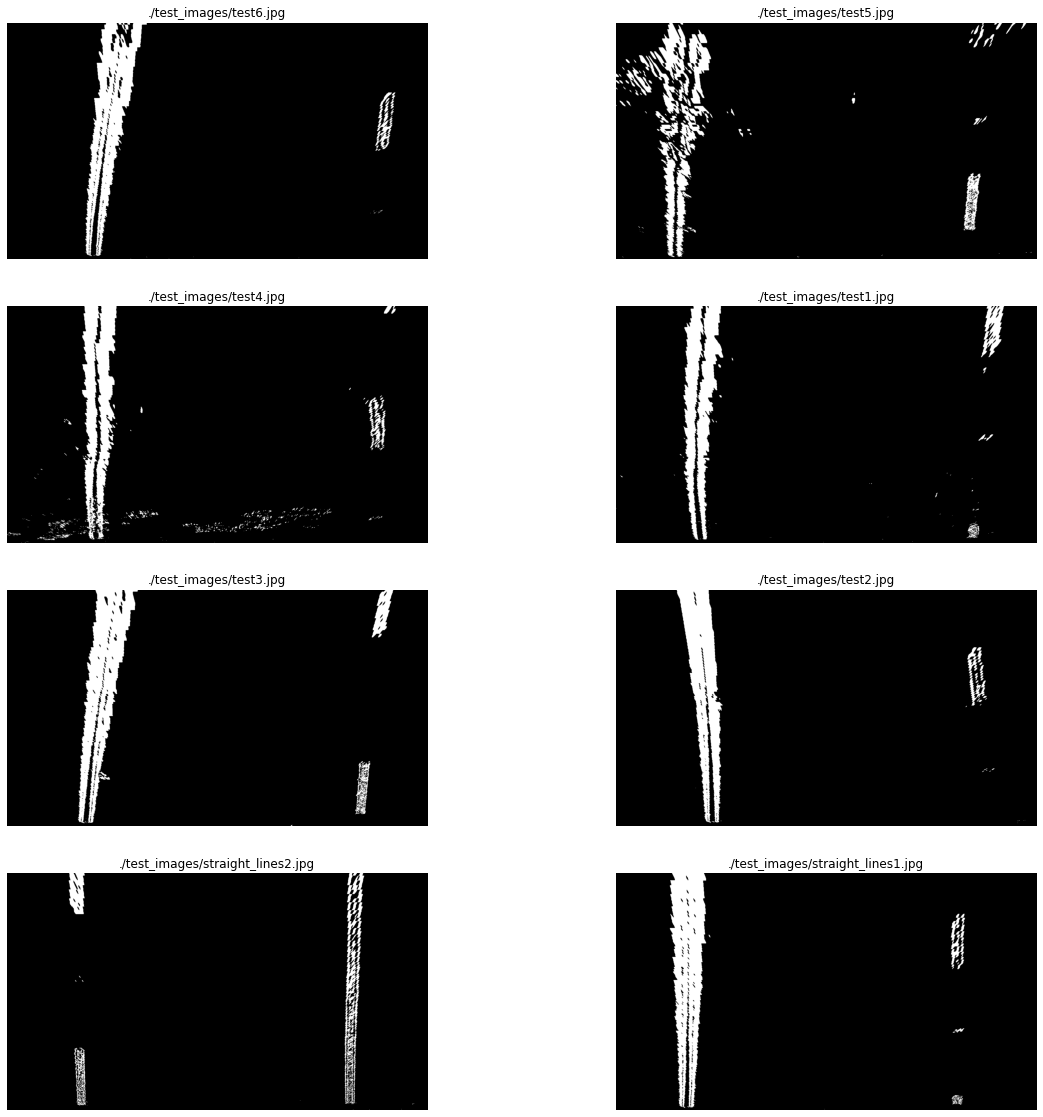

In [13]:
show_images(list(map(lambda img: (img[0],getWarped(combined_gradient(img[1]))),test_images)),cmap='gray')

## Finding Lanes

In [14]:
def find_lanes(binary_warped):
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis=0)
    out_img = np.dstack((binary_warped,binary_warped,binary_warped))*255
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) +midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
         # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(img):
    # get Warped image
    binary_warped = getWarped(combined_gradient(img))
    leftx, lefty, rightx, righty, out_img = find_lanes(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    # Plots the left and right polynomials on the lane lines
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.show()
    return out_img

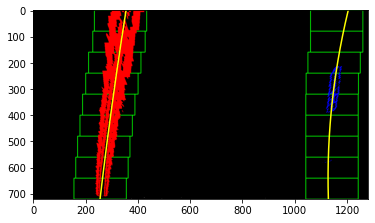

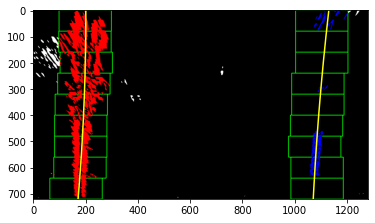

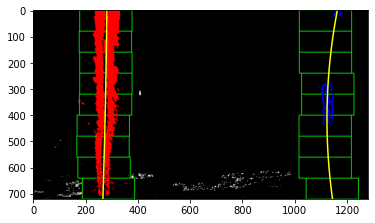

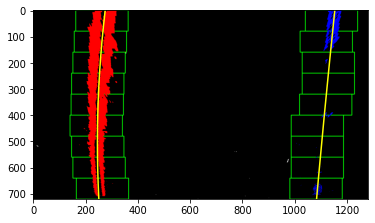

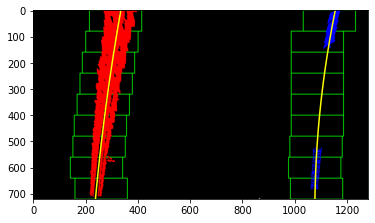

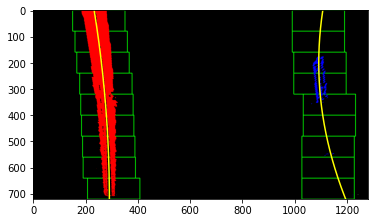

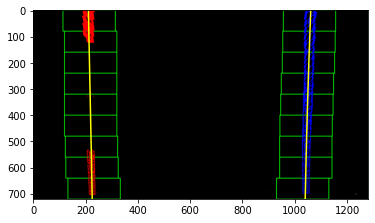

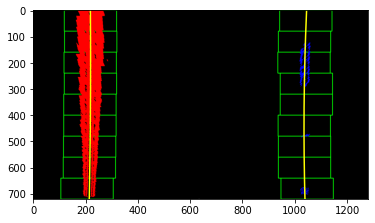

In [15]:
result = list(map(lambda img: (img[0],fit_polynomial(img[1])),test_images))

In [16]:
def draw_line(img, left_fit, right_fit):
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

## Get radius and distance

In [17]:
def calculate_radius_of_curvature(binary_warped,left_fit,right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    positionCar= binary_warped.shape[1]/2
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    
    y_eval=np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    actualPosition= (left_lane_bottom+ right_lane_bottom)/2
    
    distance= (positionCar - actualPosition)* xm_per_pix
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return (left_curverad + right_curverad)/2, distance

# Software Pipeline

In [24]:
def pipeline(img):
    binary_warped = getWarped(combined_gradient(img))
    # measure the lanes
    leftx, lefty, rightx, righty, out_img = find_lanes(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # draw the line using left_fit and right_fit
    output = draw_line(img, left_fit, right_fit)
    ouput = cv2.cvtColor( output, cv2.COLOR_BGR2RGB )
    # get radius and curvature 
    radius, distance= calculate_radius_of_curvature(binary_warped,left_fit,right_fit)
    cv2.putText(output,"Radius of Curvature is "+ str(int(radius))+ "m", (100,100), 2, 1, (0,255,0),2 )
    cv2.putText(output,"Distance from center is {:2f}".format(distance)+ "m", (100,150), 2, 1, (0,255,0),2)
    return output
    

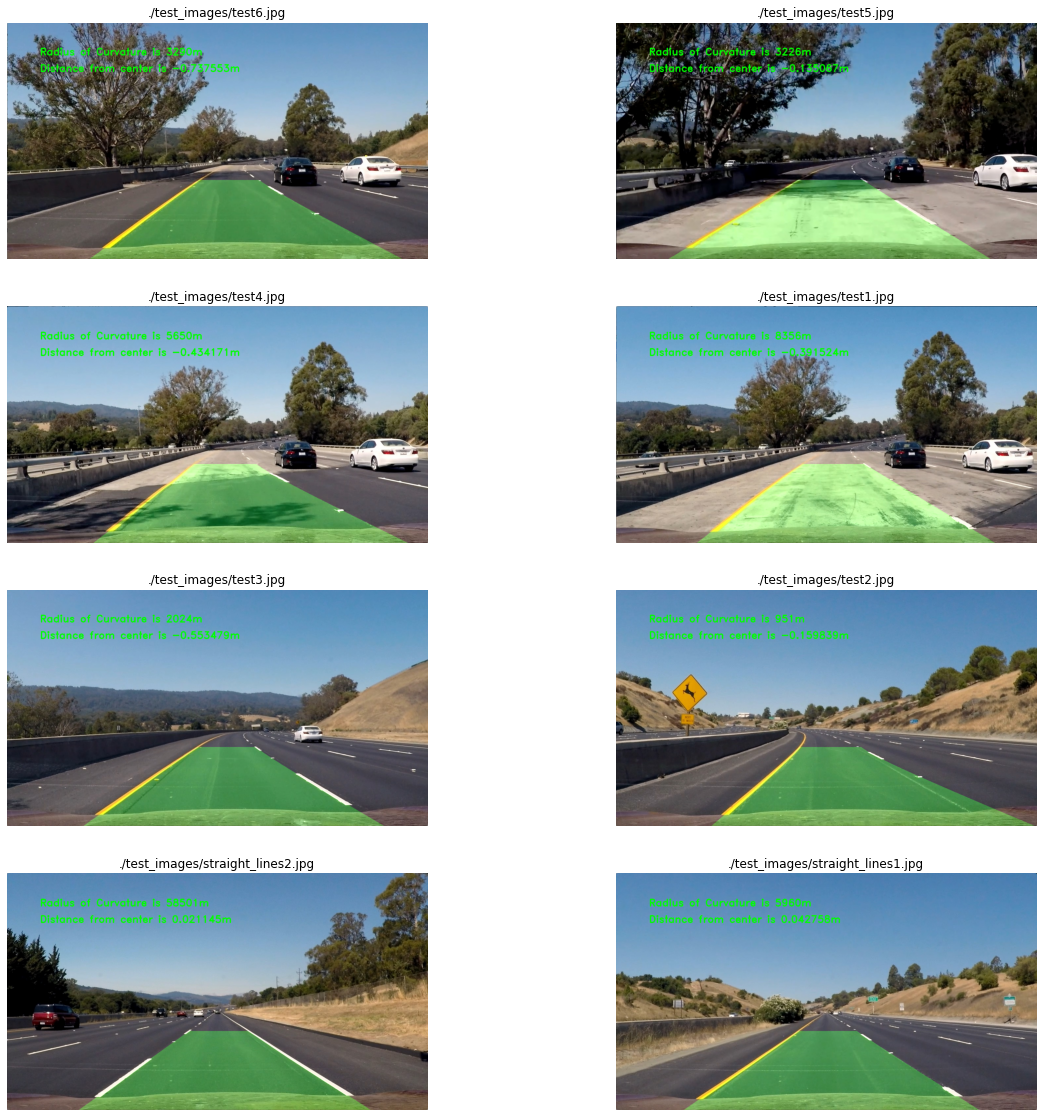

In [19]:
show_images(list(map(lambda img: (img[0],pipeline(cv2.cvtColor(img[1],cv2.COLOR_BGR2RGB))),test_images)))

In [20]:
from moviepy.editor import VideoFileClip

In [21]:
myclip = VideoFileClip('project_video.mp4')
clip = myclip.fl_image(pipeline)
clip.write_videofile('output_videos/project_video.mp4', audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
